18 Dec:

As for now, the Random Forest Regressor model capable of predict on single step forecast only (next day). To achieve for multi-step (30-daysin this case), the model should be capable to predict the independant variables as well in order to predict the dependant value.

This can be achieve using the rolling predictive approach (auto regresive style).

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def prepare_multivariate_multistep_forecast(df, forecast_horizon=30):
    """
    Prepare data for multi-step forecasting
    
    Args:
    df (pd.DataFrame): Input dataframe with preprocessed features
    forecast_horizon (int): Number of days to forecast
    
    Returns:
    tuple: Prepared features, target, scalers
    """
    # Feature preparation steps from original code
    source1 = ['Rainfall']
    source2 = ['TOTAL', 'ClimAdjust', 'ANOM']
    source3 = ['Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure']
    source4 = ['Latitude', 'Longitude', 'Elevation']

    # Create interaction features (same as original code)
    for s1 in source1:
        for s2 in source2:
            df[f'{s1}_{s2}'] = df[s1] * df[s2]        
        for s3 in source3:
            df[f'{s1}_{s3}'] = df[s1] * df[s3]
            
    for s2 in source2:
        for s3 in source3:
            df[f'{s2}_{s3}'] = df[s2] * df[s3]

    for i in range(len(source3)):
        for j in range(i + 1, len(source3)):
            df[f'{source3[i]}_{source3[j]}'] = df[source3[i]] * df[source3[j]]

    for s4 in source4:
        for s1 in source1:
            df[f'{s4}_{s1}'] = df[s4] * df[s1]
        for s2 in source2:
            df[f'{s4}_{s2}'] = df[s4] * df[s2]        
        for s3 in source3:
            df[f'{s4}_{s3}'] = df[s4] * df[s3]

    df['Rainfall_Temperature_Humidity'] = df['Rainfall'] * df['Temperature'] * df['Humidity']

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f"Rainfall_{window}d_mean"] = df["Rainfall"].rolling(window).mean()
        df[f"Rainfall_{window}d_std"] = df["Rainfall"].rolling(window).std()
        df[f"Rainfall_{window}d_sum"] = df["Rainfall"].rolling(window).sum()
        df[f"Rainfall_{window}d_min"] = df["Rainfall"].rolling(window).min()
        df[f"Rainfall_{window}d_max"] = df["Rainfall"].rolling(window).max()
        df[f"Rainfall_{window}d_median"] = df["Rainfall"].rolling(window).median()

    # Time-based features
    df['Day_of_Week'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Day_of_Year'] = df.index.dayofyear

    def cyclical_encode(data, col, max_val):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    df = cyclical_encode(df, 'Month', 12)
    df = cyclical_encode(df, 'Day_of_Week', 7)
    df = cyclical_encode(df, 'Day_of_Year', 366)
    df.drop(['Month','Day_of_Week','Day_of_Year'], axis=1, inplace=True)

    # Create lagged features for multiple variables
    for lag in range(1, 31):
        df[f'Rainfall_lag_{lag}'] = df['Rainfall'].shift(lag)
        df[f'Temperature_lag_{lag}'] = df['Temperature'].shift(lag)
        df[f'Humidity_lag_{lag}'] = df['Humidity'].shift(lag)

    df.dropna(inplace=True)

    # Correlation-based feature selection
    corr_matrix = df.iloc[:, :106].corr(method='spearman', numeric_only=True)
    corr_matrix = corr_matrix.fillna(0)
    low_corr_features = corr_matrix['Rainfall'][corr_matrix['Rainfall'].abs() < 0.1].index.tolist()
    print(f"Number of dataframe features: {len(df.columns)}")
    print(f"Number of low correlation features: {len(low_corr_features)}")
    print(f"Features with low correlation to Rainfall: {low_corr_features}")

    df_dim_red = df.drop(columns=low_corr_features)
    df_dim_red = df_dim_red.select_dtypes(include=['number'])

    # Scaling
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    features = df_dim_red.drop(columns=['Rainfall']).reset_index(drop=True)
    target = df_dim_red['Rainfall']

    features_scaled = feature_scaler.fit_transform(features)
    target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

    return features_scaled, target_scaled, feature_scaler, target_scaler, features.columns

# def multistep_forecast(df, forecast_horizon=30):
    """
    Perform multi-step forecast for specified horizon
    
    Args:
    df (pd.DataFrame): Input dataframe
    forecast_horizon (int): Number of days to forecast
    
    Returns:
    np.array: Forecasted values
    """
    # Prepare data for forecasting
    features_scaled, target_scaled, feature_scaler, target_scaler, feature_columns = prepare_multivariate_multistep_forecast(df)

    # Train test split
    x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.30, random_state=100, shuffle=False)

    # Train Random Forest model
    rf = RandomForestRegressor(
        max_depth=39, 
        max_features=None, 
        min_samples_leaf=1, 
        min_samples_split=2, 
        n_estimators=1888, 
        bootstrap=True
    )
    rf.fit(x_train, y_train.ravel())

    # Recursive forecasting
    last_known_data = x_test[-1].reshape(1, -1)
    forecast_predictions = []

    for _ in range(forecast_horizon):
        # Predict next step
        predicted_step = rf.predict(last_known_data)
        
        # Inverse transform to get actual scale
        predicted_step_actual = target_scaler.inverse_transform(predicted_step.reshape(-1, 1))[0]
        forecast_predictions.append(predicted_step_actual[0])

        # Update last known data for next iteration
        # Shift features and replace rainfall feature with new prediction
        shifted_data = np.roll(last_known_data, -1, axis=1)
        shifted_data[0, -1] = predicted_step[0]
        last_known_data = shifted_data

    return np.array(forecast_predictions)

def multistep_forecast(df, forecast_horizon=30):
    """
    Perform multi-step forecast for specified horizon
    
    Args:
    df (pd.DataFrame): Input dataframe
    forecast_horizon (int): Number of days to forecast
    
    Returns:
    dict: Contains forecasted values, input data, and model details
    """
    # Prepare data for forecasting
    features_scaled, target_scaled, feature_scaler, target_scaler, feature_columns = prepare_multivariate_multistep_forecast(df)

    # Train test split
    x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.30, random_state=100, shuffle=False)

    # Train Random Forest model
    rf = RandomForestRegressor(
        max_depth=39, 
        max_features=None, 
        min_samples_leaf=1, 
        min_samples_split=2, 
        n_estimators=1888, 
        bootstrap=True
    )
    rf.fit(x_train, y_train.ravel())

    # with open('RF_model4.pkl', 'rb') as f:
    #     rf = pickle.load(f)

    # Recursive forecasting
    last_known_data = x_test[-1].reshape(1, -1)
    forecast_predictions = []
    input_data_used = []

    # Get the last few rows of original data for context
    last_historical_data = df.iloc[-len(x_test):]

    for step in range(forecast_horizon):
        # Predict next step
        predicted_step = rf.predict(last_known_data)
        
        # Inverse transform to get actual scale
        predicted_step_actual = target_scaler.inverse_transform(predicted_step.reshape(-1, 1))[0]
        forecast_predictions.append(predicted_step_actual[0])

        # Prepare input data for tracking
        # Convert scaled input back to original scale
        current_input_scaled = last_known_data.reshape(-1)
        current_input_original = feature_scaler.inverse_transform(current_input_scaled.reshape(1, -1))[0]
        
        input_data_used.append({
            'scaled_input': current_input_scaled,
            'original_input': current_input_original,
            'features': feature_columns.tolist()
        })

        # Update last known data for next iteration
        # Shift features and replace rainfall feature with new prediction
        shifted_data = np.roll(last_known_data, -1, axis=1)
        shifted_data[0, -1] = predicted_step[0]
        last_known_data = shifted_data

    return {
        'forecast_values': np.array(forecast_predictions),
        'input_data': input_data_used,
        'model': {
            'type': 'RandomForestRegressor',
            'params': {
                'max_depth': 39,
                'max_features': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'n_estimators': 1888,
                'bootstrap': True
            }
        },
        'last_historical_data': last_historical_data
    }

# def plot_forecast(original_df, forecast_values):
    """
    Plot original data and forecast
    
    Args:
    original_df (pd.DataFrame): Original dataframe
    forecast_values (np.array): Forecasted rainfall values
    """
    plt.figure(figsize=(15, 6))
    plt.plot(original_df.index, original_df['Rainfall'], label='Historical Rainfall', color='blue', linestyle='-', linewidth=2)

    plt.plot(original_df.index[-len(forecast_values):], forecast_values, label='Forecast', color='orange', alpha=0.6, linestyle='--', linewidth=2)

    plt.title('Rainfall Forecast')
    plt.xlabel('Date')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()

def plot_forecast(result):
    """
    Plot original data and forecast
    
    Args:
    result (dict): Forecast result from multistep_forecast
    """
    plt.figure(figsize=(15, 6))
    
    # Plot historical data
    historical_data = result['last_historical_data']
    plt.plot(historical_data.index, historical_data['Rainfall'], 
            label='Historical Rainfall', color='blue')
    
    # Prepare forecast dates
    last_date = historical_data.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=len(result['forecast_values'])+1)[1:]
    
    # Plot forecast
    plt.plot(forecast_dates, result['forecast_values'], 
            label='Forecast', color='orange', alpha=0.6, linestyle='--')
    
    plt.title('Rainfall Forecast')
    plt.xlabel('Date')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming df is your original DataFrame loaded with datetime index
# forecast = multistep_forecast(df)
# plot_forecast(df, forecast)

In [23]:
df = pd.read_csv('lawas/lawas-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_10192\3343875640.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
C:\Users\User\AppData\Local\Temp\ipykernel_10192\3343875640.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
C:\Users\User\AppData\Local\Temp\ipykernel_10192\3343875640.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

Number of dataframe features: 202
Number of low correlation features: 48
Features with low correlation to Rainfall: ['TOTAL', 'ClimAdjust', 'ANOM', 'DewPoint', 'WindSpeed', 'Pressure', 'Latitude', 'Longitude', 'Elevation', 'Rainfall_ANOM', 'TOTAL_DewPoint', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_DewPoint', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_Visibility', 'ANOM_WindSpeed', 'ANOM_Pressure', 'Temperature_WindSpeed', 'DewPoint_WindSpeed', 'DewPoint_Pressure', 'Humidity_Visibility', 'Humidity_WindSpeed', 'Visibility_WindSpeed', 'WindSpeed_Pressure', 'Latitude_TOTAL', 'Latitude_ClimAdjust', 'Latitude_ANOM', 'Latitude_DewPoint', 'Latitude_WindSpeed', 'Latitude_Pressure', 'Longitude_TOTAL', 'Longitude_ClimAdjust', 'Longitude_ANOM', 'Longitude_DewPoint', 'Longitude_WindSpeed', 'Longitude_Pressure', 'Elevation_TOTAL', 'Elevation_ClimAdjust', 'Elevation_ANOM', 'Elevation_DewPoint', 'Elevation_WindSpeed', 'Elevation_P

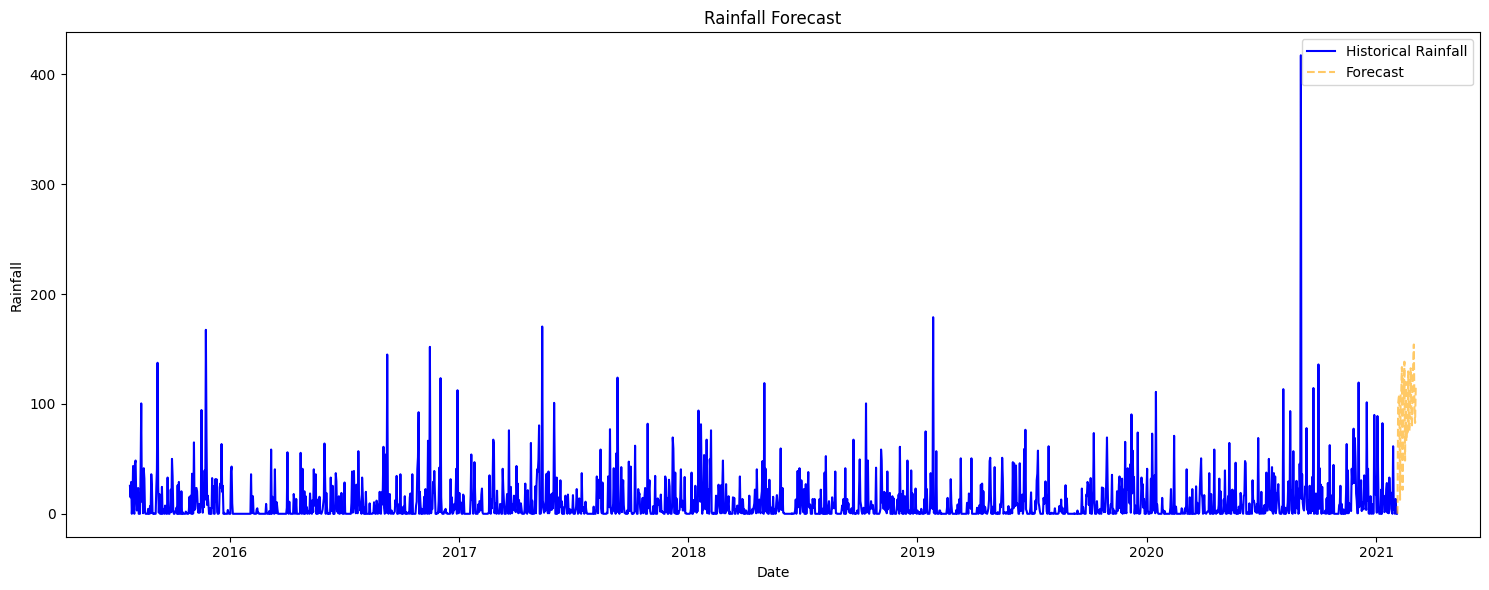

In [24]:
forecast_result = multistep_forecast(df)
plot_forecast(forecast_result)

In [20]:
for i, data in enumerate(forecast_result['input_data']):
    print(f"Step {i + 1}:")
    print("Scaled Input:")
    print(data['scaled_input'])
    print("Original Input:")
    print(data['original_input'])
    print("Features:")
    print(data['features'])
    print("-" * 40)

Step 1:
Scaled Input:
[0.3947929  0.57615894 1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.27661062
 0.41942988 0.85784351 0.32933193 0.54849486 0.95152057 0.34709497
 0.56340711 0.89327335 0.39811349 0.53807012 0.89941081 0.57659601
 0.99290014 0.         0.3947929  0.57615894 1.         0.
 0.3947929  0.57615894 1.         0.         0.3947929  0.57615894
 1.         0.         0.16896235 0.14264876 0.16896235 0.
 0.14730539 0.08421053 0.24048816 0.15759989 0.24048816 0.
 0.14730539 0.1440678  0.38495575 0.238159   0.38495575 0.19760479
 0.2        0.9330127  0.75       1.         0.35689587 0.77556097
 0.91721906 0.00958084 0.44       0.57174393 0.03233533 0.50461538
 0.5419426  0.         0.53538462 0.47130243 0.02155689 0.48307692
 0.5        0.00958084 0.59384615 0.38741722 0.14730539 0.55076923
 0.55960265 0.         0.50461538 0.51986755 0.00359281 0.49846154
 0.56732892 0.01077844 0.43692308 0.60927152 0.04670659 0.44307692
 0.60

In [26]:
input_data_list = forecast_result['input_data']
df_input_data = pd.DataFrame({
    'Step': range(1, len(input_data_list) + 1),
    'Scaled Input': [data['scaled_input'] for data in input_data_list],
    'Original Input': [data['original_input'] for data in input_data_list],
    'Features': [data['features'] for data in input_data_list],
})

# Display the DataFrame
df_input_data.to_csv("input_data.csv")

In [33]:
input_data = forecast_result['input_data']

# Extract 'scaled_input' and 'original_input' from 'input_data'
scaled_input = [entry['scaled_input'] for entry in input_data]
original_input = [entry['original_input'] for entry in input_data]
features = input_data[0]['features']  # Assumes all entries have the same features

# Create DataFrames
scaled_input_df = pd.DataFrame(scaled_input, columns=features)
original_input_df = pd.DataFrame(original_input, columns=features)



In [36]:
original_input_df.to_csv("original_input.csv",index=False)